In [ ]:
from os import path
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

from tensorflow.keras.layers import Input, Layer, BatchNormalization, Add, Lambda, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

import time
from tqdm.keras import TqdmCallback
import h5py

#### **Retrieve data: a set of protein sequences, each one associated with some label.** 

The labels indicate the [Pfam](https://pfam.xfam.org) families to which the sequences belong to. The sequences belonging to the same family share some sequence and structural similarity, indicative of a common ancestry and common function(s).

In [ ]:
!gdown --id '1ZRKQdrYu0tCT7kW-tmbpJ3N9ov9igbQG'
!gdown --id '1Me9zJth8PV7z4LCYttjVNQnEwBMD9K4W'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZRKQdrYu0tCT7kW-tmbpJ3N9ov9igbQG
To: /content/input.fasta
100% 42.0k/42.0k [00:00<00:00, 59.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Me9zJth8PV7z4LCYttjVNQnEwBMD9K4W
To: /content/input.csv
100% 43.8k/43.8k [00:00<00:00, 60.4MB/s]


Read the labels and store them in a data frame.

In [ ]:
df = pd.read_csv('/content/input.csv')
df

,UniprotId,Seq,Class
0,A0A671VDZ5/18-86,INLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLTLRQIRFRFD...,PF11976
1,A0A2T4H7P2/23-88,IKVTDNNNEVFFKIKRTTKLEKLMGAFCERQGKATSSVRFLFDGTR...,PF11976
2,A0A2A3EG26/7-35,CPCCKELFVEPVLLPCWHALCLACAVNLQ,PF00097
3,A0A384DIE7/467-542,VVLHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDRI...,PF00595
4,A0A481BKW6/137-162,WVENKTPDGKVYYYNARTRESAWTKP,PF00397
...,...,...,...
315,A0A7K8W4C1/12-154,RLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIPGKKGTPW...,PF00179
316,A0A5G2QLK1/21-90,IKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFE...,PF11976
317,A0A4C1UXA4/662-858,GLEATLPNSYCNPMLQVLYYTLPIKDVLLTHTCAKEFCLSCQLGFL...,PF13423
318,A0A7M7II71/230-320,DSHGFGICVKGGKDAGEIRSTFRLPPSPYFAPQDRGVGVYISRVEE...,PF00595


#### **Questions**

- How many protein sequences do  we have?
- What are the minimum and maximum lengths of the sequences?

Write some code in the cell below to find the answers!

# The Protein Language Model ProSE ([Bepler and Berger 2019](https://arxiv.org/pdf/1902.08661.pdf))

The neural network architecture is a bi-directional LSTM. It was pre-trained on millions of sequences with the task of predicting some masked amino acid, given the previous ones and the following ones (the full context).

The first step here is to retrieve the pre-trained model, define by an architecture and the associated weights.

In [ ]:
!git clone https://github.com/tbepler/prose.git

Cloning into 'prose'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 1), reused 23 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [ ]:
!wget -nc -P prose/ http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip

--2022-07-25 09:32:28--  http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
Resolving bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)... 128.30.48.147
Connecting to bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)|128.30.48.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581846360 (555M) [application/zip]
Saving to: ‘prose/saved_models.zip’

saved_models.zip    100%[===================>] 554.89M  80.5MB/s    in 7.1s    

2022-07-25 09:32:35 (78.6 MB/s) - ‘prose/saved_models.zip’ saved [581846360/581846360]



In [ ]:
!unzip -q -n prose/saved_models.zip -d prose/

In [ ]:
#!pip install -r prose/requirements.txt

The second step is to use the pre-trained model to compute an "embedding" for each input protein sequence. The output of the model is a matrix of floats with dimensions L x D, where L is the length of the sequence (number of amino acids) and D is the encodding dimension. 

As a post-processing step, the full embedding matrix is "reduced" to a vector. This operation allows representing every sequences as a fixed-size vector, where the size  is the dimension D. How should we aggregate the per-residue embeddings into a single vector representing the protein? Here, you can try to compute the sum, the max, or the average.

In [ ]:
#@title Compute the embeddings (pooling types: sum, max, avg)
pooling_type = 'avg' #@param {type : "string"}
!rm prose/data/output.h5
!echo 'Chosen Pooling method is' {pooling_type}
!python3 prose/embed_sequences.py --pool {pooling_type} -o prose/data/output.h5 /content/input.fasta

rm: cannot remove 'prose/data/output.h5': No such file or directory
Chosen Pooling method is avg
# loading the pre-trained ProSE MT model
# writing: prose/data/output.h5
# embedding with pool=avg


In [ ]:
hf_embeddings = h5py.File('prose/data/output.h5', 'r')
embeddings = {x: np.array(hf_embeddings[x]) for x in df.UniprotId.to_list()}

We can check that the identifiers of the sequences are indeed the same in the dictionary storing the embeddings (keys) and in the data frame storing the labels.

In [ ]:
print(list(embeddings.keys())[:10])
print(list(df.UniprotId.to_list())[:10])

['A0A671VDZ5/18-86', 'A0A2T4H7P2/23-88', 'A0A2A3EG26/7-35', 'A0A384DIE7/467-542', 'A0A481BKW6/137-162', 'A0A3P9DKY7/475-591', 'A0A316YP75/8-46', 'A0A2R8PDT9/22-91', 'A0A6J2WFH4/12-52', 'A0A6J0SWF7/652-705']
['A0A671VDZ5/18-86', 'A0A2T4H7P2/23-88', 'A0A2A3EG26/7-35', 'A0A384DIE7/467-542', 'A0A481BKW6/137-162', 'A0A3P9DKY7/475-591', 'A0A316YP75/8-46', 'A0A2R8PDT9/22-91', 'A0A6J2WFH4/12-52', 'A0A6J0SWF7/652-705']


In [ ]:
print(embeddings['A0A671VDZ5/18-86'])

[ 0.02898551  0.07246377  0.02898551 ...  0.04140409  0.08653378
 -0.00195555]


#### **Questions**

- What is the dimension D?  (write some code below)

Now, we are going to define X and y variables representing our processed inputs (the embeddings) and the labels (Pfam family). We encode the labels in one-hot vectors. This will be useful later on for performing supervised classification (see below).

In [ ]:
X = np.vstack(list(embeddings.values()))

classes = set(df.Class.to_list())
labels = [[c] for c in classes]
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot = encoder.fit(asarray(labels))
y = df.Class.apply(lambda x: encoder.transform([[x]])[0]).to_list()
y = np.vstack(y)

print(X.shape)
print(y.shape)
print(y[0])
print(classes)

(320, 6165)
(320, 8)
[0. 0. 0. 0. 0. 0. 1. 0.]
{'PF13423', 'PF00179', 'PF00172', 'PF00397', 'PF00097', 'PF11976', 'PF00145', 'PF00595'}


We also define some weights that will determine the respective contributions of the label classes during the training phase. For this, we need to know how balanced our training set, in other words how many samples we have for each class. Here, the classes are balanced (same number of samples for each) so we will put the same weight (1) to every clases.

In [ ]:
#Finding weights for each class
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(sorted(df.Class.to_list())),
                                                  y = sorted(df.Class.to_list()))
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}

#### **Visualise and interpret the embeddings** 

Here, we perform a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) analysis to project the embeddings, which are of very high diemnsion, to only 2 dimensions, to be able to visualise them and see how they group together. t-SNE is a non-linear dimensionality reduction technique. It defines a measure of similarity for each pair of points in high dimension. The aim of the the aanalysis is to find a map in 2D that preserves these similarities. In practice, the difference between the similarity distribution in the low dimensional space (2D) and the similarity distribution in high dimensional space (the target distribution) is minimized using the Kullback-Leibler divergence. Once the points are plotted in 2D, we can color them according to the labels. This can be seeen as "zero-shot prediction" of the labels.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


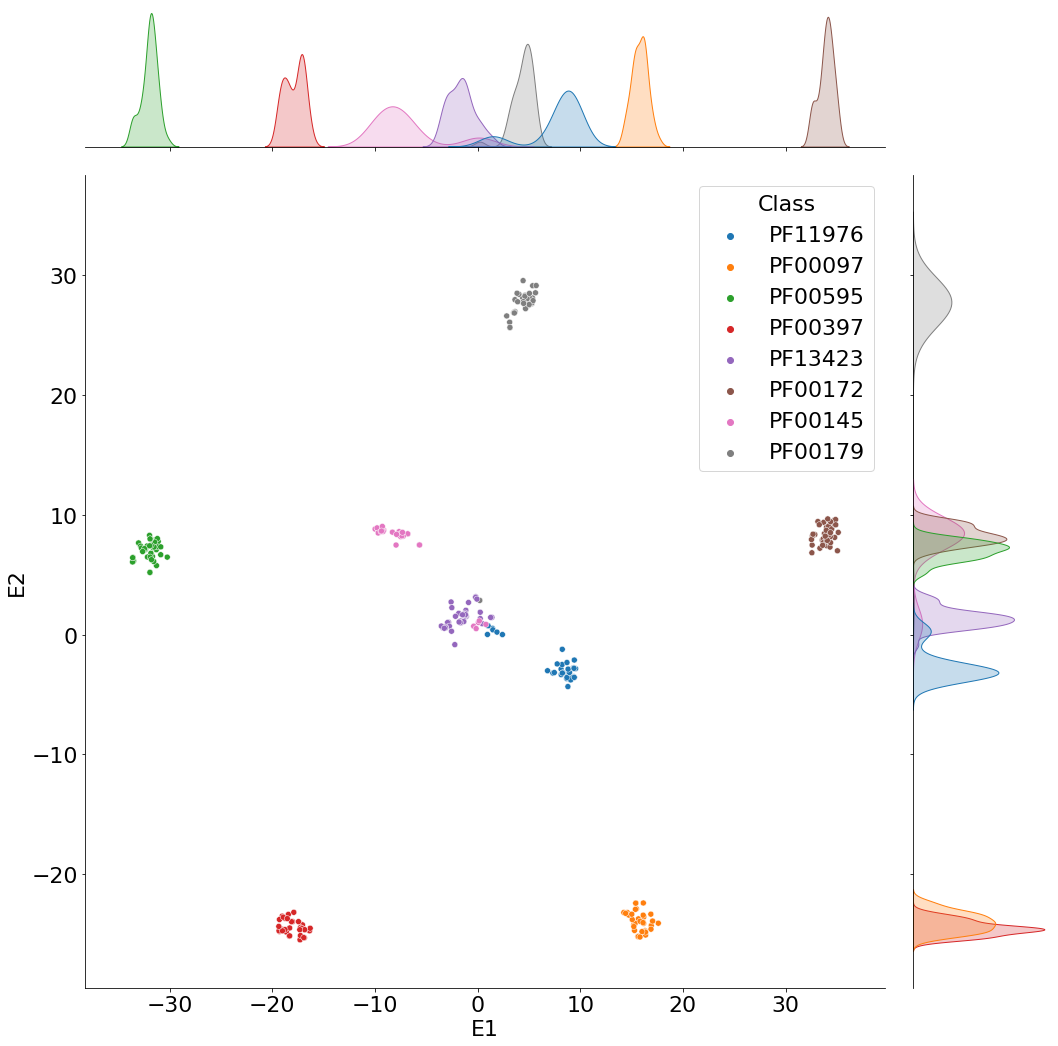

In [ ]:
X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X)

df['E1'] = X_embedded[:,0]
df['E2'] = X_embedded[:,1]

#plt.rcParams.update({'font.size': 10})
sns.jointplot(data=df, x='E1', y='E2', hue = 'Class', height=15)

#### **Questions**

- To what  extent do the projections of the embeddings allow to segregate the different Pfam families? Is this result expected?

Try to change the aggregation operation for goiong from ressidue-based embeddings to protein-based embeddings to see how it affects the projections. You can also investigate the parts that are not well segregated.

In [ ]:
df_new = df[(df.E1.between(0,10)) & (df.E2.between(0,10))]
df_new

,UniprotId,Seq,Class,E1,E2
21,A0A7K1RDA1/424-497,NIRAASGGSSRSYVAQQWAVRRLLPQECERLQGFDDDYTNVPWRGK...,PF00145,0.221851,1.104965
30,A0A673L3S7/15-45,RQIRFRFDGQPINETDTPAQLEMEDEDTIDV,PF11976,1.452280,0.528495
38,A0A3P9DT30/3-67,KTDQDHAAEQAEGASLYDLVATVPHILDAGAGGNLVAHIKVGETYH...,PF13423,0.464097,0.917415
41,A8IN82/424-472,AGLENDLPNAYCNALFQALYFLPEFRGLVLAHVPEPDAEFCLTCELGFL,PF13423,0.262274,1.874383
49,A0A2U1J6J9/466-533,FKIKIRSKLGKDIYMDIAKSVKISFVIEAYKKACELGNEVKVKLSF...,PF11976,1.493699,0.402538
82,I1QEI1/40-107,TLKVQGTDGRAVYRTMLRTEQLQGLMDFYYDRSHGRVQRGTGRFLF...,PF11976,1.029087,0.744911
91,A0A093IYH3/2-76,FMNKIFHPNIDEASGTVCLDVINQTWTALYDLTNIFESFLPQLLAY...,PF00179,0.219762,2.861031
109,A0A446KT19/25-92,TLKVRNTDGHTVYRTMRRTEQLQSLMDFYYASVPAVQPGTGRFLYD...,PF11976,0.965262,0.016883
150,A0A396GB00/57-121,ININVKGQDGNVTLVCIDRSTQLKKLVKDYCDQHSVEDPTSITFWF...,PF11976,1.892881,0.213199
155,A0A0M8MVG0/223-347,PRSNSEVALNFDQKPVVGICLKRYSMDAQGIPQRNGTYIDIPDSLR...,PF13423,1.401257,1.442899


#### **Downstream task: classification**

Here, we will perform supervised learning as a downstream task to improve the segregation of the Pfam families. For this, we will build a very simple architecture of 3 dense (fully connected) layers of neurons. The numbers of neurons are 1000, 500, and 100 respectively. The final layer is of the size of the output (number of classes) and equipped with a softmax to normalize the predictions. The outut is a probability vector, whose distance to the one-hot encoding of the label is minimized during training.

We first split our set into training and test subsets. Then, we define the architecture. You may change the activation function (elu) and the loss (categorical cross-entopy) for your tests.

You can specify the number of epochs (number of times the machine will see the input samples) and the batch size (number of samples considered at each update of the parameters).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
def get_model(input_shape):
    X_in = Input(shape=input_shape)
    H = Dense(1000, use_bias=True, activation='elu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(X_in)
    H = Dense(500, use_bias=True, activation='elu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
    H = Dense(100, use_bias=True, activation='elu', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), kernel_constraint=max_norm(4), bias_constraint=max_norm(4))(H)
    Y = Dense(len(classes), activation='softmax')(H)

    _model = Model(inputs=[X_in], outputs=Y)
    _model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
    _model.summary()
    
    return _model

In [ ]:
num_epochs = 50 #@param {type : "number"}
batch_size = 50 #@param {type : "number"}

In [ ]:
model = get_model(6165)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs, verbose=0, class_weight=d_class_weights, callbacks=[TqdmCallback(verbose=2)])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6165)]            0         
                                                                 
 dense_11 (Dense)            (None, 1000)              6166000   
                                                                 
 dense_12 (Dense)            (None, 500)               500500    
                                                                 
 dense_13 (Dense)            (None, 100)               50100     
                                                                 
 dense_14 (Dense)            (None, 8)                 808       
                                                                 
Total params: 6,717,408
Trainable params: 6,717,408
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

  0%|          | 0.00/5.00 [00:00<?, ?batch/s]

In [ ]:
def plot_train_val_loss(history):
  plt.figure(figsize=(10,10))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss by epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='right')
  plt.savefig('tf_trainvalcurve_scr_classificaiton.svg')

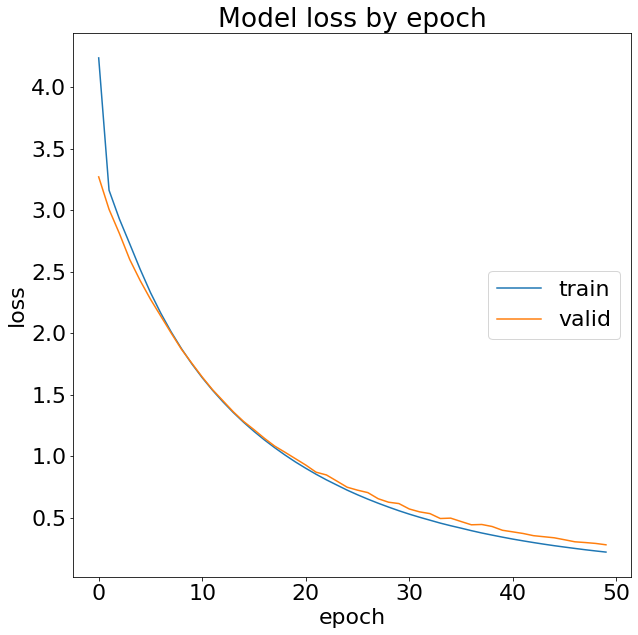

In [ ]:
plot_train_val_loss(history)

Designed by **Yasser MOHSENI BEHBAHANI** and **Élodie LAINE**, LCQB, Sorbonne Université, 2022

<img src='https://drive.google.com/uc?id=1shvaqXgnRa2aCji30gJ02hwI_Ux6NEp6'>